<a href="https://colab.research.google.com/github/bec2148/mnist-finalproject/blob/main/CIFAR10_distillation_edge_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Base code https://pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import time

NUM_EPOCHS = 1

# Check if GPU is available, and if not, use the CPU
print("torch.cuda.is_available()", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.is_available() False


In [2]:
# Below we are preprocessing data for CIFAR-10. We use an arbitrary batch size of 128.
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading the CIFAR-10 dataset:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Comment back in for efficiency

from torch.utils.data import Subset
num_images_to_keep = 2000
train_dataset = Subset(train_dataset, range(min(num_images_to_keep, 50_000)))
test_dataset = Subset(test_dataset, range(min(num_images_to_keep, 10_000)))

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Subjective brightness
RED = 0.299
GREEN = 0.587
BLUE = 0.114

# CIFAR-10 class names
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

all_images.shape  torch.Size([2000, 3, 32, 32])
bw.shape  torch.Size([2000, 32, 32])
padded.shape  torch.Size([2000, 34, 34])


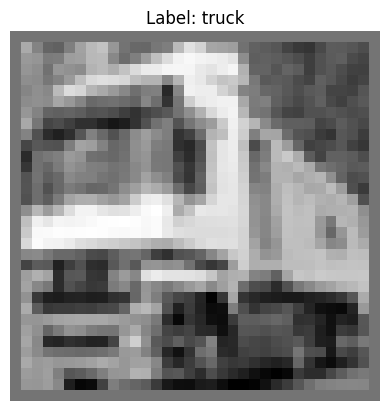

updown.shape  torch.Size([2000, 32, 32])
leftright.shape  torch.Size([2000, 32, 32])


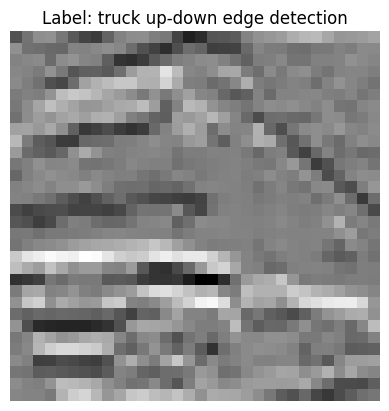

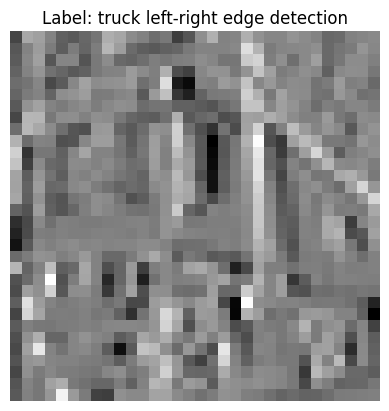

new_images.shape  torch.Size([2000, 5, 32, 32])


In [5]:
# calculate deltas for edge detection in training images
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

# Load all data in one batch
all_train_images, all_train_labels = next(iter(train_loader))

print("all_images.shape ", all_train_images.shape)
bw = all_train_images[:, 0, :, :] * RED + all_train_images[:, 1, :, :] * GREEN + all_train_images[:, 1, :, :] * BLUE
print("bw.shape ", bw.shape)
padded = F.pad(bw, pad=(1, 1, 1, 1, 0, 0), mode='constant', value=0)
print("padded.shape ", padded.shape)

plt.imshow(padded[1], cmap='gray')
plt.title(f"Label: {CLASS_NAMES[all_train_labels[1]]}")
plt.axis('off')
plt.show()

updown = (padded[:, 0:32, :] - padded[:, 1:33, :])[:, 0:32, 1:33]
leftright = (padded[:, :, 0:32] - padded[:, :, 1:33])[:, 1:33, 0:32]
print("updown.shape ", updown.shape)
print("leftright.shape ", leftright.shape)

plt.imshow(updown[1], cmap='gray')
plt.title(f"Label: {CLASS_NAMES[all_train_labels[1]]} up-down edge detection")
plt.axis('off')
plt.show()

plt.imshow(leftright[1], cmap='gray')
plt.title(f"Label: {CLASS_NAMES[all_train_labels[1]]} left-right edge detection")
plt.axis('off')
plt.show()

train_images_w_edges = torch.cat((all_train_images, updown.unsqueeze(1), leftright.unsqueeze(1)), dim=1)
print("new_images.shape ", train_images_w_edges.shape)

all_test_images.shape  torch.Size([2000, 3, 32, 32])
bw.shape  torch.Size([2000, 32, 32])
padded.shape  torch.Size([2000, 34, 34])


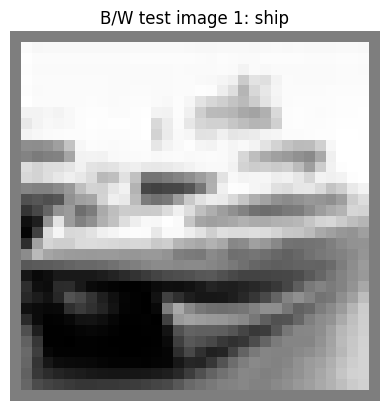

updown.shape  torch.Size([2000, 32, 32])
leftright.shape  torch.Size([2000, 32, 32])
test_images_w_edges.shape  torch.Size([2000, 5, 32, 32])


In [6]:
# Calculate edges for test data
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# Load all data in one batch
all_test_images, all_test_labels = next(iter(test_loader))

print("all_test_images.shape ", all_test_images.shape)
bw = all_test_images[:, 0, :, :] * RED + all_test_images[:, 1, :, :] * GREEN + all_test_images[:, 1, :, :] * BLUE
print("bw.shape ", bw.shape)
padded = F.pad(bw, pad=(1, 1, 1, 1, 0, 0), mode='constant', value=0)
print("padded.shape ", padded.shape)

plt.imshow(padded[1], cmap='gray')
plt.title(f"B/W test image 1: {CLASS_NAMES[all_test_labels[1]]}")
plt.axis('off')
plt.show()

updown = (padded[:, 0:32, :] - padded[:, 1:33, :])[:, 0:32, 1:33]
leftright = (padded[:, :, 0:32] - padded[:, :, 1:33])[:, 1:33, 0:32]
print("updown.shape ", updown.shape)
print("leftright.shape ", leftright.shape)

test_images_w_edges = torch.cat((all_test_images, updown.unsqueeze(1), leftright.unsqueeze(1)), dim=1)
print("test_images_w_edges.shape ", test_images_w_edges.shape)


In [7]:
# subclass Dataset to process images with 2 more channels (left-right edges, and up-down edges)
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        # The length of the dataset is the number of images
        return len(self.images)

    def __getitem__(self, idx):
        # Return the image and label at the given index
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

# Create instances of the custom dataset
train_dataset = CustomDataset(train_images_w_edges, all_train_labels)
test_dataset = CustomDataset(test_images_w_edges, all_test_labels)

In [8]:
#Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [9]:
# Deeper neural network class to be used as teacher:
class DeepNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(5, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(5, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [10]:
def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            print("type(inputs)", type(inputs))
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [11]:
torch.manual_seed(42)
nn_deep = DeepNN(num_classes=10).to(device)
start_teacher_train = time.perf_counter()
train(nn_deep, train_loader, epochs=NUM_EPOCHS, learning_rate=0.001, device=device)
end_teacher_train = time.perf_counter()
teacher_train_seconds = end_teacher_train - start_teacher_train
test_accuracy_deep = test(nn_deep, test_loader, device)

# Instantiate the lightweight network:
torch.manual_seed(42)
nn_light = LightNN(num_classes=10).to(device)

type(inputs) <class 'torch.Tensor'>
type(inputs) <class 'torch.Tensor'>
type(inputs) <class 'torch.Tensor'>
type(inputs) <class 'torch.Tensor'>
type(inputs) <class 'torch.Tensor'>
type(inputs) <class 'torch.Tensor'>
type(inputs) <class 'torch.Tensor'>
type(inputs) <class 'torch.Tensor'>
type(inputs) <class 'torch.Tensor'>
type(inputs) <class 'torch.Tensor'>
type(inputs) <class 'torch.Tensor'>
type(inputs) <class 'torch.Tensor'>
type(inputs) <class 'torch.Tensor'>
type(inputs) <class 'torch.Tensor'>
type(inputs) <class 'torch.Tensor'>
type(inputs) <class 'torch.Tensor'>
Epoch 1/1, Loss: 2.192146047949791
Test Accuracy: 26.35%


In [12]:
torch.manual_seed(42)
new_nn_light = LightNN(num_classes=10).to(device)

In [13]:
# Print the norm of the first layer of the initial lightweight model
print("Norm of 1st layer of nn_light:", torch.norm(nn_light.features[0].weight).item())
# Print the norm of the first layer of the new lightweight model
print("Norm of 1st layer of new_nn_light:", torch.norm(new_nn_light.features[0].weight).item())

Norm of 1st layer of nn_light: 2.3401336669921875
Norm of 1st layer of new_nn_light: 2.3401336669921875


In [14]:
## Print the total number of parameters in each model:

total_params_deep = "{:,}".format(sum(p.numel() for p in nn_deep.parameters()))
print(f"DeepNN parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in nn_light.parameters()))
print(f"LightNN parameters: {total_params_light}")

DeepNN parameters: 1,189,290
LightNN parameters: 268,026


In [15]:
## Train and test the lightweight network with cross entropy loss:

#### train(nn_light, train_loader, epochs=NUM_EPOCHS, learning_rate=0.001, device=device)
#### test_accuracy_light_ce = test(nn_light, test_loader, device)

In [16]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
#### print(f"Student accuracy: {test_accuracy_light_ce:.2f}%")

Teacher accuracy: 26.35%


In [17]:
## Distillation loss is calculated from the logits of the networks. It only returns gradients to the student:

def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
start_student_distill = time.perf_counter()
train_knowledge_distillation(teacher=nn_deep, student=new_nn_light, train_loader=train_loader, epochs=NUM_EPOCHS, learning_rate=0.001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)
end_student_distill = time.perf_counter()
test_accuracy_light_ce_and_kd = test(new_nn_light, test_loader, device)

# Compare the student test accuracy with and without the teacher, after distillation
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
#### print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")

Epoch 1/1, Loss: 1.6316213011741638
Test Accuracy: 30.10%
Teacher accuracy: 26.35%
Student accuracy with CE + KD: 30.10%


In [18]:
class ModifiedDeepNNRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedDeepNNRegressor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        conv_feature_map = x
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, conv_feature_map

class ModifiedLightNNRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedLightNNRegressor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Include an extra regressor (in our case linear)
        self.regressor = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        regressor_output = self.regressor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, regressor_output

In [19]:
print(f"Teacher training time: {teacher_train_seconds: 0.4f} seconds")
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
#### print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")


Teacher training time:  33.3774 seconds
Teacher accuracy: 26.35%
Student accuracy with CE + KD: 30.10%
